In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz

%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Merge

In [2]:
df1 = pd.read_csv("diabetic_data.csv",low_memory=False)

In [3]:
df1

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,MC,?,51,0,16,0,0,0,250.13,291,458,9,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,MC,?,33,3,18,0,0,1,560,276,787,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,53,0,9,1,0,0,38,590,296,13,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [5]:
df2 = pd.read_csv("admissions_mapping.csv",low_memory=False)

In [6]:
df2

,admission_type_id,admission_type_description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


In [7]:
df3 = pd.merge(left=df1,right=df2,how='inner',left_on='admission_type_id',right_on='admission_type_id')

In [8]:
df3

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_description
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,NaN
1,1968528,720936,Caucasian,Female,[70-80),?,6,25,1,10,?,Surgery-Cardiovascular/Thoracic,56,2,24,0,0,0,440,413,250.52,9,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,NaN
2,2040360,661014,Caucasian,Male,[60-70),?,6,25,7,9,?,Family/GeneralPractice,61,4,25,0,0,0,410,428,411,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO,NaN
3,2088630,1719279,Caucasian,Male,[40-50),?,6,25,7,11,?,Family/GeneralPractice,68,0,25,0,0,0,428,867,250.6,9,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,Ch,Yes,>30,NaN
4,2091690,7919802,AfricanAmerican,Female,[40-50),?,6,25,7,6,?,InternalMedicine,47,2,13,0,0,0,578,285,401,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,343730600,141434069,Caucasian,Female,[80-90),?,7,11,7,1,MC,?,1,2,5,0,0,0,430,432,250,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,Trauma Center
101762,389059568,141433160,Caucasian,Female,[80-90),?,7,3,7,4,MC,?,66,0,16,0,0,0,852,427,851,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Trauma Center
101763,402583472,141357506,AfricanAmerican,Male,[50-60),?,7,3,7,6,MC,?,61,1,14,0,0,0,952,707,344,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,Trauma Center
101764,403231316,141466478,Caucasian,Male,[10-20),?,7,6,7,9,MD,?,45,6,23,0,0,0,821,813,958,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Trauma Center


In [9]:
df3.shape

(101766, 51)

### Data Cleaning

In [10]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 51 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   encounter_id                101766 non-null  int64 
 1   patient_nbr                 101766 non-null  int64 
 2   race                        101766 non-null  object
 3   gender                      101766 non-null  object
 4   age                         101766 non-null  object
 5   weight                      101766 non-null  object
 6   admission_type_id           101766 non-null  int64 
 7   discharge_disposition_id    101766 non-null  int64 
 8   admission_source_id         101766 non-null  int64 
 9   time_in_hospital            101766 non-null  int64 
 10  payer_code                  101766 non-null  object
 11  medical_specialty           101766 non-null  object
 12  num_lab_procedures          101766 non-null  int64 
 13  num_procedures              1

In [11]:
df3.isnull().sum()

encounter_id                     0
patient_nbr                      0
race                             0
gender                           0
age                              0
weight                           0
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                       0
medical_specialty                0
num_lab_procedures               0
num_procedures                   0
num_medications                  0
number_outpatient                0
number_emergency                 0
number_inpatient                 0
diag_1                           0
diag_2                           0
diag_3                           0
number_diagnoses                 0
max_glu_serum                    0
A1Cresult                        0
metformin                        0
repaglinide                      0
nateglinide                      0
chlorpropamide                   0
glimepiride         

In [12]:
df3['admission_type_description'].fillna(value='unknown',inplace=True)

In [13]:
df3

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_description
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,unknown
1,1968528,720936,Caucasian,Female,[70-80),?,6,25,1,10,?,Surgery-Cardiovascular/Thoracic,56,2,24,0,0,0,440,413,250.52,9,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,unknown
2,2040360,661014,Caucasian,Male,[60-70),?,6,25,7,9,?,Family/GeneralPractice,61,4,25,0,0,0,410,428,411,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO,unknown
3,2088630,1719279,Caucasian,Male,[40-50),?,6,25,7,11,?,Family/GeneralPractice,68,0,25,0,0,0,428,867,250.6,9,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,Ch,Yes,>30,unknown
4,2091690,7919802,AfricanAmerican,Female,[40-50),?,6,25,7,6,?,InternalMedicine,47,2,13,0,0,0,578,285,401,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,343730600,141434069,Caucasian,Female,[80-90),?,7,11,7,1,MC,?,1,2,5,0,0,0,430,432,250,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,Trauma Center
101762,389059568,141433160,Caucasian,Female,[80-90),?,7,3,7,4,MC,?,66,0,16,0,0,0,852,427,851,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Trauma Center
101763,402583472,141357506,AfricanAmerican,Male,[50-60),?,7,3,7,6,MC,?,61,1,14,0,0,0,952,707,344,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,Trauma Center
101764,403231316,141466478,Caucasian,Male,[10-20),?,7,6,7,9,MD,?,45,6,23,0,0,0,821,813,958,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Trauma Center


In [14]:
df3.isnull().sum()

encounter_id                  0
patient_nbr                   0
race                          0
gender                        0
age                           0
weight                        0
admission_type_id             0
discharge_disposition_id      0
admission_source_id           0
time_in_hospital              0
payer_code                    0
medical_specialty             0
num_lab_procedures            0
num_procedures                0
num_medications               0
number_outpatient             0
number_emergency              0
number_inpatient              0
diag_1                        0
diag_2                        0
diag_3                        0
number_diagnoses              0
max_glu_serum                 0
A1Cresult                     0
metformin                     0
repaglinide                   0
nateglinide                   0
chlorpropamide                0
glimepiride                   0
acetohexamide                 0
glipizide                     0
glyburid

### Clean Missing Values

In [15]:
df3['weight'].value_counts()

?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

In [16]:
df3.replace(to_replace='?',value = 0, inplace=True)

In [17]:
df3

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_description
0,2278392,8222157,Caucasian,Female,[0-10),0,6,25,1,1,0,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,0,0,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,unknown
1,1968528,720936,Caucasian,Female,[70-80),0,6,25,1,10,0,Surgery-Cardiovascular/Thoracic,56,2,24,0,0,0,440,413,250.52,9,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,unknown
2,2040360,661014,Caucasian,Male,[60-70),0,6,25,7,9,0,Family/GeneralPractice,61,4,25,0,0,0,410,428,411,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO,unknown
3,2088630,1719279,Caucasian,Male,[40-50),0,6,25,7,11,0,Family/GeneralPractice,68,0,25,0,0,0,428,867,250.6,9,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,Ch,Yes,>30,unknown
4,2091690,7919802,AfricanAmerican,Female,[40-50),0,6,25,7,6,0,InternalMedicine,47,2,13,0,0,0,578,285,401,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,343730600,141434069,Caucasian,Female,[80-90),0,7,11,7,1,MC,0,1,2,5,0,0,0,430,432,250,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,Trauma Center
101762,389059568,141433160,Caucasian,Female,[80-90),0,7,3,7,4,MC,0,66,0,16,0,0,0,852,427,851,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Trauma Center
101763,402583472,141357506,AfricanAmerican,Male,[50-60),0,7,3,7,6,MC,0,61,1,14,0,0,0,952,707,344,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,Trauma Center
101764,403231316,141466478,Caucasian,Male,[10-20),0,7,6,7,9,MD,0,45,6,23,0,0,0,821,813,958,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Trauma Center


In [18]:
#Save to csv
#df3.to_csv('train.csv',index=False)

In [19]:
df3['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [20]:
df3['readmitted'] = df3['readmitted'].map({'NO':'NO','>30':'YES','<30':'YES'})

In [21]:
df3

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_description
0,2278392,8222157,Caucasian,Female,[0-10),0,6,25,1,1,0,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,0,0,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,unknown
1,1968528,720936,Caucasian,Female,[70-80),0,6,25,1,10,0,Surgery-Cardiovascular/Thoracic,56,2,24,0,0,0,440,413,250.52,9,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,YES,unknown
2,2040360,661014,Caucasian,Male,[60-70),0,6,25,7,9,0,Family/GeneralPractice,61,4,25,0,0,0,410,428,411,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO,unknown
3,2088630,1719279,Caucasian,Male,[40-50),0,6,25,7,11,0,Family/GeneralPractice,68,0,25,0,0,0,428,867,250.6,9,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,Ch,Yes,YES,unknown
4,2091690,7919802,AfricanAmerican,Female,[40-50),0,6,25,7,6,0,InternalMedicine,47,2,13,0,0,0,578,285,401,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,343730600,141434069,Caucasian,Female,[80-90),0,7,11,7,1,MC,0,1,2,5,0,0,0,430,432,250,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,Trauma Center
101762,389059568,141433160,Caucasian,Female,[80-90),0,7,3,7,4,MC,0,66,0,16,0,0,0,852,427,851,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Trauma Center
101763,402583472,141357506,AfricanAmerican,Male,[50-60),0,7,3,7,6,MC,0,61,1,14,0,0,0,952,707,344,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,Trauma Center
101764,403231316,141466478,Caucasian,Male,[10-20),0,7,6,7,9,MD,0,45,6,23,0,0,0,821,813,958,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Trauma Center


In [22]:
df3['readmitted'].value_counts()

NO     54864
YES    46902
Name: readmitted, dtype: int64

In [23]:
#df3.to_csv('train.csv',index=False)

### Data Exploration

In [24]:
df3['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
0                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [25]:
df3['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [26]:
df3['age'].value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

In [27]:
df3['weight'].value_counts()

0            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

In [28]:
df3['discharge_disposition_id'].value_counts()

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

In [29]:
df3['admission_source_id'].value_counts()

7     57494
1     29565
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
11        2
14        2
25        2
13        1
Name: admission_source_id, dtype: int64

In [30]:
df3['time_in_hospital'].value_counts()

3     17756
2     17224
1     14208
4     13924
5      9966
6      7539
7      5859
8      4391
9      3002
10     2342
11     1855
12     1448
13     1210
14     1042
Name: time_in_hospital, dtype: int64

In [31]:
df3['payer_code'].value_counts()

0     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64

In [32]:
df3['medical_specialty'].value_counts()

0                                   49949
InternalMedicine                    14635
Emergency/Trauma                     7565
Family/GeneralPractice               7440
Cardiology                           5352
                                    ...  
Surgery-PlasticwithinHeadandNeck        1
Speech                                  1
Pediatrics-InfectiousDiseases           1
Neurophysiology                         1
SportsMedicine                          1
Name: medical_specialty, Length: 73, dtype: int64

In [33]:
df3['max_glu_serum'].value_counts()

None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

In [34]:
df3['A1Cresult'].value_counts()

None    84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

In [35]:
df3['change'].value_counts()

No    54755
Ch    47011
Name: change, dtype: int64

In [36]:
df3['diabetesMed'].value_counts()

Yes    78363
No     23403
Name: diabetesMed, dtype: int64

In [37]:
df3.describe(include='all')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_description
count,1.017660e+05,1.017660e+05,101766,101766,101766,101766.0,101766.000000,101766.000000,101766.000000,101766.000000,101766.0,101766.0,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766,101766,101766,101766.000000,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,NaN,NaN,6,3,10,10.0,NaN,NaN,NaN,NaN,18.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,717,749,790,NaN,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,2,8
top,NaN,NaN,Caucasian,Female,[70-80),0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,428,276,250,NaN,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency
freq,NaN,NaN,76099,54708,26068,98569.0,NaN,NaN,NaN,NaN,40256.0,49949.0,NaN,NaN,NaN,NaN,NaN,NaN,6862,6752,11555,NaN,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864,53990
mean,1.652016e+08,5.433040e+07,NaN,NaN,NaN,NaN,2.024006,3.715642,5.754437,4.395987,NaN,NaN,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,NaN,NaN,NaN,7.422607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.026403e+08,3.869636e+07,NaN,NaN,NaN,NaN,1.445403,5.280166,4.064081,2.985108,NaN,NaN,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,NaN,NaN,NaN,1.933600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.496119e+07,2.341322e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,NaN,NaN,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.523890e+08,4.550514e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,NaN,NaN,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.302709e+08,8.754595e+07,NaN,NaN,NaN,NaN,3.000000,4.000000,7.000000,6.000000,NaN,NaN,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df4 = df3.drop(['encounter_id','patient_nbr','race','gender','age','weight','admission_type_id',
                'discharge_disposition_id','admission_source_id','payer_code','medical_specialty',
               'admission_type_description'],axis=1)

In [39]:
df4

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,1,41,0,1,0,0,0,250.83,0,0,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,10,56,2,24,0,0,0,440,413,250.52,9,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,YES
2,9,61,4,25,0,0,0,410,428,411,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
3,11,68,0,25,0,0,0,428,867,250.6,9,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,Ch,Yes,YES
4,6,47,2,13,0,0,0,578,285,401,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,1,2,5,0,0,0,430,432,250,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101762,4,66,0,16,0,0,0,852,427,851,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
101763,6,61,1,14,0,0,0,952,707,344,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101764,9,45,6,23,0,0,0,821,813,958,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO


In [40]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 39 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   time_in_hospital          101766 non-null  int64 
 1   num_lab_procedures        101766 non-null  int64 
 2   num_procedures            101766 non-null  int64 
 3   num_medications           101766 non-null  int64 
 4   number_outpatient         101766 non-null  int64 
 5   number_emergency          101766 non-null  int64 
 6   number_inpatient          101766 non-null  int64 
 7   diag_1                    101766 non-null  object
 8   diag_2                    101766 non-null  object
 9   diag_3                    101766 non-null  object
 10  number_diagnoses          101766 non-null  int64 
 11  max_glu_serum             101766 non-null  object
 12  A1Cresult                 101766 non-null  object
 13  metformin                 101766 non-null  object
 14  repa

In [41]:
#df4.to_csv('train.csv',index=False)

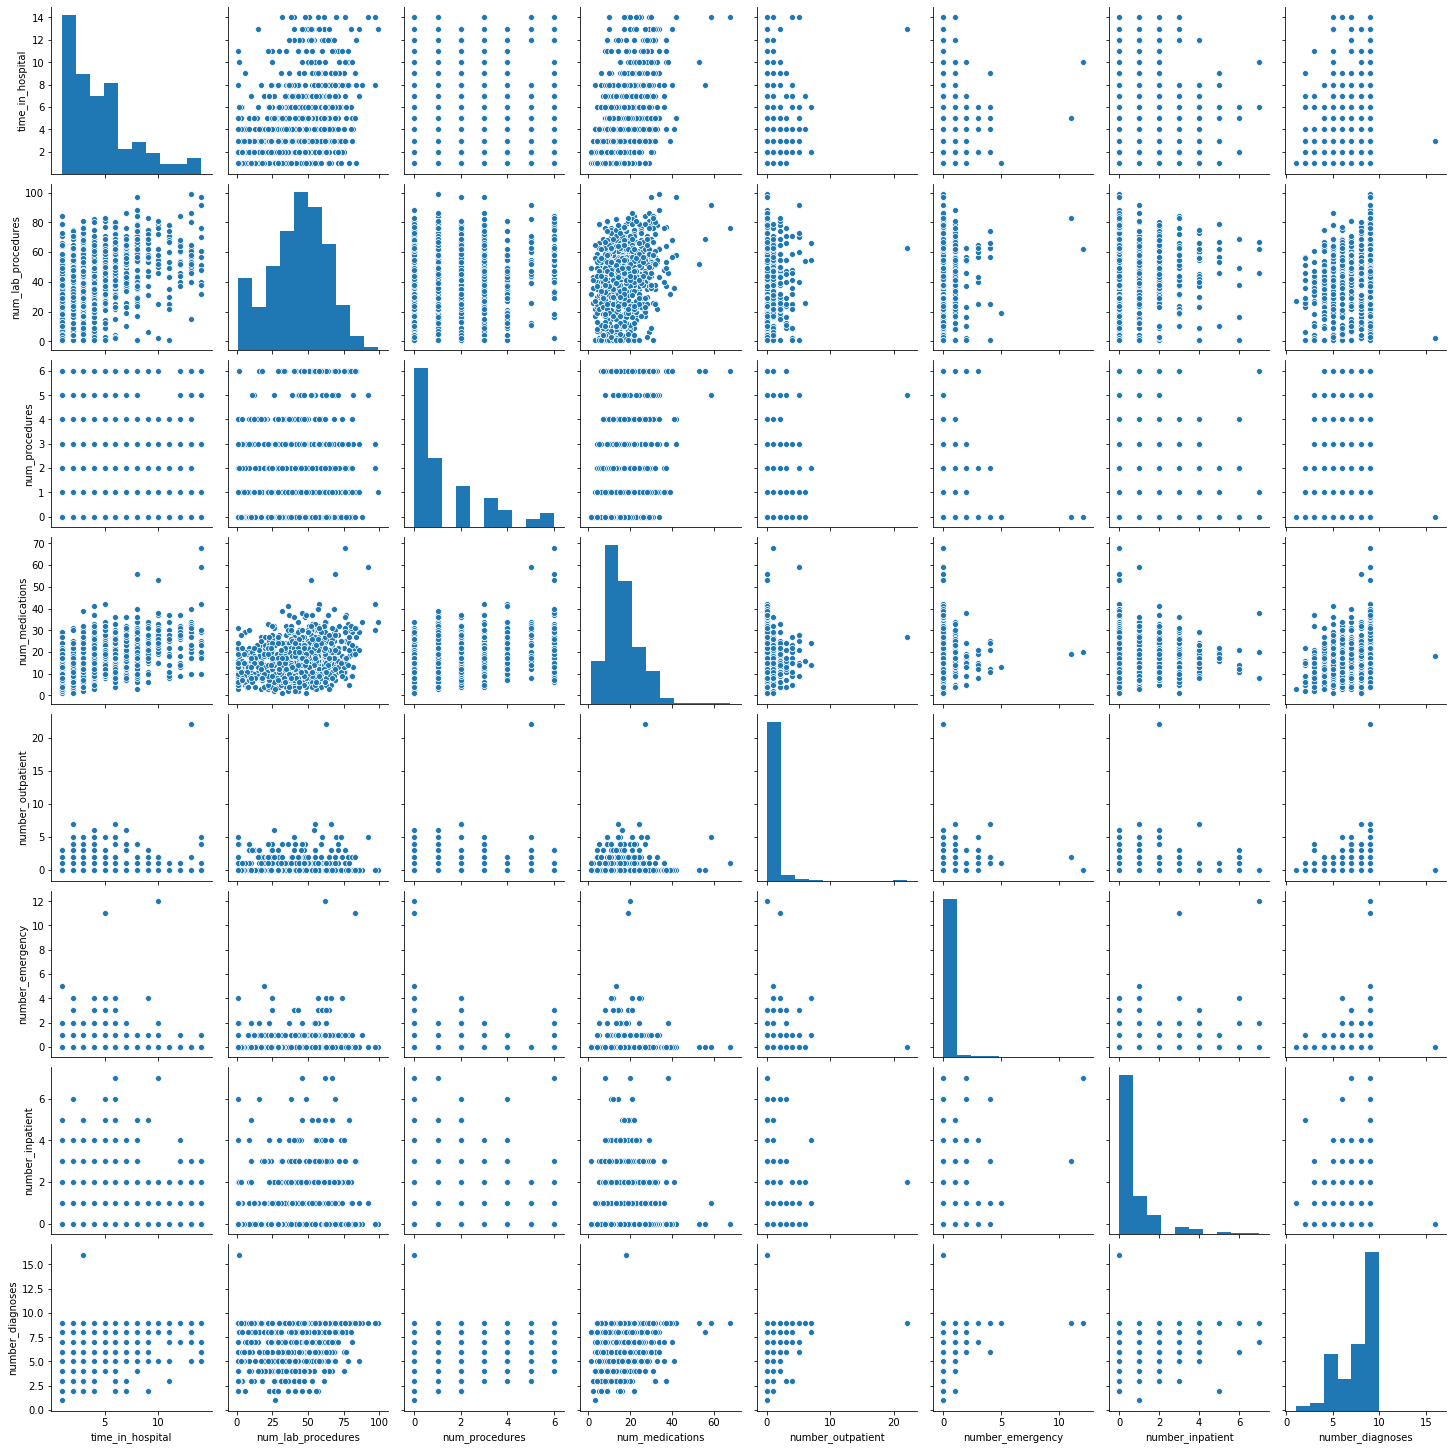

In [42]:
sns.pairplot(df4.sample(1000))
plt.show()

In [43]:
df4['diag_1'].value_counts()

428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
V25       1
V07       1
838       1
145       1
84        1
Name: diag_1, Length: 717, dtype: int64

In [44]:
df4['diag_2'].value_counts()

276     6752
428     6662
250     6071
427     5036
401     3736
        ... 
E918       1
E968       1
674        1
843        1
833        1
Name: diag_2, Length: 749, dtype: int64

In [45]:
df4['diag_3'].value_counts()

250     11555
401      8289
276      5175
428      4577
427      3955
        ...  
972         1
193         1
463         1
876         1
E955        1
Name: diag_3, Length: 790, dtype: int64

In [46]:
df4['metformin'].value_counts()

No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64

In [47]:
df5 = df4.drop(['diag_1','diag_2','diag_3','max_glu_serum','A1Cresult'],axis=1)

In [48]:
df5

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,1,41,0,1,0,0,0,1,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,10,56,2,24,0,0,0,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,YES
2,9,61,4,25,0,0,0,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
3,11,68,0,25,0,0,0,9,No,No,No,No,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,Ch,Yes,YES
4,6,47,2,13,0,0,0,8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,1,2,5,0,0,0,7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101762,4,66,0,16,0,0,0,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
101763,6,61,1,14,0,0,0,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101764,9,45,6,23,0,0,0,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO


In [49]:
#df5.to_csv('train.csv',index=False)

### Data Visualization

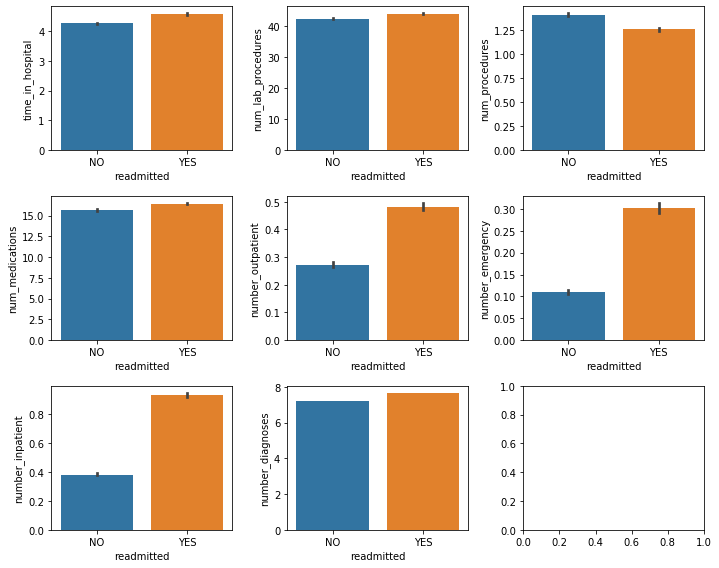

In [50]:
fig = plt.figure(figsize=(10,8))

plt.subplot(3,3,1)
sns.barplot(x=df5.readmitted, y=df5.time_in_hospital)
plt.subplot(3,3,2)
sns.barplot(x=df5.readmitted, y=df5.num_lab_procedures)
plt.subplot(3,3,3)
sns.barplot(x=df5.readmitted, y=df5.num_procedures)
plt.subplot(3,3,4)
sns.barplot(x=df5.readmitted, y=df5.num_medications)
plt.subplot(3,3,5)
sns.barplot(x=df5.readmitted, y=df5.number_outpatient)
plt.subplot(3,3,6)
sns.barplot(x=df5.readmitted, y=df5.number_emergency)
plt.subplot(3,3,7)
sns.barplot(x=df5.readmitted, y=df5.number_inpatient)
plt.subplot(3,3,8)
sns.barplot(x=df5.readmitted, y=df5.number_diagnoses)
plt.subplot(3,3,9)

plt.tight_layout()

In [51]:
df6 = df5.drop(['metformin','repaglinide','nateglinide','chlorpropamide',
               'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
               'rosiglitazone' ,'acarbose' ,'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
               'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone' ,
                'metformin-rosiglitazone', 'metformin-pioglitazone'],axis=1)

In [52]:
df6

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,readmitted
0,1,41,0,1,0,0,0,1,No,No,NO
1,10,56,2,24,0,0,0,9,Ch,Yes,YES
2,9,61,4,25,0,0,0,9,Ch,Yes,NO
3,11,68,0,25,0,0,0,9,Ch,Yes,YES
4,6,47,2,13,0,0,0,8,No,No,NO
...,...,...,...,...,...,...,...,...,...,...,...
101761,1,1,2,5,0,0,0,7,No,Yes,NO
101762,4,66,0,16,0,0,0,9,No,No,NO
101763,6,61,1,14,0,0,0,9,No,Yes,NO
101764,9,45,6,23,0,0,0,9,No,No,NO


In [53]:
#df6.to_csv('train.csv',index=False)

### Data Preprocessing

In [54]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   time_in_hospital    101766 non-null  int64 
 1   num_lab_procedures  101766 non-null  int64 
 2   num_procedures      101766 non-null  int64 
 3   num_medications     101766 non-null  int64 
 4   number_outpatient   101766 non-null  int64 
 5   number_emergency    101766 non-null  int64 
 6   number_inpatient    101766 non-null  int64 
 7   number_diagnoses    101766 non-null  int64 
 8   change              101766 non-null  object
 9   diabetesMed         101766 non-null  object
 10  readmitted          101766 non-null  object
dtypes: int64(8), object(3)
memory usage: 14.3+ MB


In [55]:
encoder = LabelEncoder()

In [56]:
df6['readmitted'] = encoder.fit_transform(df6['readmitted'])

In [57]:
df6

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,readmitted
0,1,41,0,1,0,0,0,1,No,No,0
1,10,56,2,24,0,0,0,9,Ch,Yes,1
2,9,61,4,25,0,0,0,9,Ch,Yes,0
3,11,68,0,25,0,0,0,9,Ch,Yes,1
4,6,47,2,13,0,0,0,8,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...
101761,1,1,2,5,0,0,0,7,No,Yes,0
101762,4,66,0,16,0,0,0,9,No,No,0
101763,6,61,1,14,0,0,0,9,No,Yes,0
101764,9,45,6,23,0,0,0,9,No,No,0


In [58]:
df7 = pd.get_dummies(df6, drop_first=True)

In [59]:
df7

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,change_No,diabetesMed_Yes
0,1,41,0,1,0,0,0,1,0,1,0
1,10,56,2,24,0,0,0,9,1,0,1
2,9,61,4,25,0,0,0,9,0,0,1
3,11,68,0,25,0,0,0,9,1,0,1
4,6,47,2,13,0,0,0,8,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
101761,1,1,2,5,0,0,0,7,0,1,1
101762,4,66,0,16,0,0,0,9,0,1,0
101763,6,61,1,14,0,0,0,9,0,1,1
101764,9,45,6,23,0,0,0,9,0,1,0


In [60]:
df7 = df7[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
           'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
           'change_No', 'diabetesMed_Yes', 'readmitted' ]]

In [61]:
df7

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change_No,diabetesMed_Yes,readmitted
0,1,41,0,1,0,0,0,1,1,0,0
1,10,56,2,24,0,0,0,9,0,1,1
2,9,61,4,25,0,0,0,9,0,1,0
3,11,68,0,25,0,0,0,9,0,1,1
4,6,47,2,13,0,0,0,8,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
101761,1,1,2,5,0,0,0,7,1,1,0
101762,4,66,0,16,0,0,0,9,1,0,0
101763,6,61,1,14,0,0,0,9,1,1,0
101764,9,45,6,23,0,0,0,9,1,0,0


In [62]:
#df7.to_csv('train.csv',index=False)

### Train a Classification Model

In [63]:
X = df7.iloc[:,0:10]
y = df7.iloc[:,10]

In [64]:
X.values, y.values

(array([[ 1, 41,  0, ...,  1,  1,  0],
        [10, 56,  2, ...,  9,  0,  1],
        [ 9, 61,  4, ...,  9,  0,  1],
        ...,
        [ 6, 61,  1, ...,  9,  1,  1],
        [ 9, 45,  6, ...,  9,  1,  0],
        [ 3, 64,  1, ...,  9,  0,  1]], dtype=int64),
 array([0, 1, 0, ..., 0, 0, 0]))

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [66]:
X_train.shape, X_test.shape

((61059, 10), (40707, 10))

In [67]:
xgb = XGBClassifier(random_state=123, n_estimators=400, objective='binary:logistic')

In [68]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=20)

[0]	validation_0-error:0.383398
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.384406
[2]	validation_0-error:0.383398
[3]	validation_0-error:0.384356
[4]	validation_0-error:0.383398
[5]	validation_0-error:0.383448
[6]	validation_0-error:0.383251
[7]	validation_0-error:0.3833
[8]	validation_0-error:0.384332
[9]	validation_0-error:0.382907
[10]	validation_0-error:0.382883
[11]	validation_0-error:0.384332
[12]	validation_0-error:0.382932
[13]	validation_0-error:0.382981
[14]	validation_0-error:0.382907
[15]	validation_0-error:0.381875
[16]	validation_0-error:0.382047
[17]	validation_0-error:0.38163
[18]	validation_0-error:0.380107
[19]	validation_0-error:0.380082
[20]	validation_0-error:0.380549
[21]	validation_0-error:0.380279
[22]	validation_0-error:0.379247
[23]	validation_0-error:0.379542
[24]	validation_0-error:0.379149
[25]	validation_0-error:0.379222
[26]	validation_0-error:0.379443
[27]	validation_0-error:0.379689
[28]	validation_0-error

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [69]:
y_pred = xgb.predict(X_test)

In [70]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

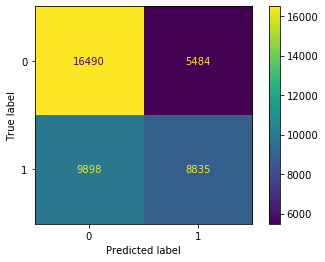

In [71]:
plot_confusion_matrix(xgb,X_test,y_test,values_format='.6g')
plt.show()

In [72]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.75      0.68     21974
           1       0.62      0.47      0.53     18733

    accuracy                           0.62     40707
   macro avg       0.62      0.61      0.61     40707
weighted avg       0.62      0.62      0.61     40707



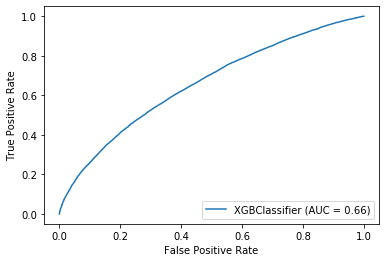

In [73]:
plot_roc_curve(xgb,X_test,y_test)
plt.show()